#### Пример.

*Рассчитать и построить линию чёрного тела, линии постоянной КЦТ на  равноконтрастном графике МКО 1960.*

Линия чёрного тела (а точнее координаты цветности, лежащие на ней) необходима для построения изотемпературных линий. Поэтому приведём здесь алгоритм её построения.

Загружаем необходимые библиотеки.

In [1]:
from colorimetry import *
import numpy as np 
import pandas as pd
from scipy.misc import derivative
from scipy import interpolate
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Формируем список T температур.

In [2]:
mired = np.arange(10, 500, 40)
T = 1e6/mired
#T = np.arange(2000,10000, 300)
T;

Вычисляем координаты цветности чёрного тела u, v для температур из списка T

In [3]:
uv_bbline = {}

for t in T:
    spd = plank(t)
    xyz_color_coordinates = XYZ(spd)
    xy_chromacity = XYZ2xy(xyz_color_coordinates)
    uv_chromacity = xy2uv(xy_chromacity)
    uv_bbline[t] = uv_chromacity

uv_bbline = pd.DataFrame(uv_bbline).T
uv_bbline

,u,v
100000.000000,0.180632,0.265972
20000.000000,0.183868,0.277151
11111.111111,0.188788,0.290011
7692.307692,0.195564,0.303035
5882.352941,0.204072,0.315090
4761.904762,0.214028,0.325599
4000.000000,0.225109,0.334396
3448.275862,0.237018,0.341537
3030.303030,0.249509,0.347184
2702.702703,0.262376,0.351535


Частные производные $u'$, $v'$ найдём с помощью функции `derivative` из пакета `scipy`. Функция `derivative` имеет два обязательных параметра --- дифференцируемую функцию и точку, в которой ищется производная. В нашем случае дифференцируемая функция --- это  зависимость координаты цветности от температуры чёрного тела $u(t)$ (или $v(t)$), а точка --- это  значение температуры. 

Функция `derivative` для вычисления производной использует формулу центральной разности: 
\begin{equation}
y' \approx \dfrac{\Delta y}{\Delta x} = \dfrac{y_{i+1} - y_{i-1}}{x_{i+1} - x_{i-1}}=\dfrac{y_{i+1} - y_{i-1}}{2h}
\end{equation}

![Центральная разность](fig/derivative.svg.png)

Обратите внимание при
передаче дифференцируемой функции (vgen или ugen) в derivative после имени
функции скобки не ставятся. В данном случае функции vgen и ugen не вызываются, а просто передаются функции derivative как обычные объекты. Вызваны
они будут уже внутри derivative для соответствующих приращений параметра t.


In [4]:
def vgen(t):
    plank_spd = plank(t)
    xyz = XYZ(plank_spd)
    xy = XYZ2xy(xyz)
    uv = xy2uv(xy)
    return uv['v']

def ugen(t):
    plank_spd = plank(t)
    xyz = XYZ(plank_spd)
    xy = XYZ2xy(xyz)
    uv = xy2uv(xy)
    return uv['u']


dvt = [derivative(vgen, t) for t in T]
dut = [derivative(ugen, t) for t in T]

dvt = np.array(dvt)
dut = np.array(dut)

Для того чтобы построить линию постоянной коррелированной цветовой температуры нужно найти координаты  двух точек лежащих на перепендикуляре к линии чёрного тела. Формулы \eqref{eq:isoth} позволяют найти координаты точек, которые равноудалены от линии чёрного тела.

In [5]:
l = 0.04 # l --- расстояние от линии чёрного тела

upoz = uv_bbline['u'].values + l*dvt/np.sqrt(dvt**2 + dut**2)
vpoz = uv_bbline['v'].values - l*dut/np.sqrt(dvt**2 + dut**2)
uneg = uv_bbline['u'].values - l*dvt/np.sqrt(dvt**2 + dut**2)
vneg = uv_bbline['v'].values + l*dut/np.sqrt(dvt**2 + dut**2)

Совершим последние действия перед отрисовкой, а именно найдём координаты цветности (u, v)  спектральных цветов. Для чего сначала загрузим удельные координаты цвета МКО 1931. Потом найдём координаты цветности (x, y) спектральных цветов и преобразуем их в координаты цветности (u, v).    

In [6]:
xyz_cmf = pd.read_csv('ciexyz31_1.csv', index_col = 0)
xy_spectr_color = XYZ2xy(xyz_cmf) 
uv_spectr_color = xy2uv(xy_spectr_color)
uv_spectr_color = pd.DataFrame(uv_spectr_color)

# Из DataFrame объекта uv_spectr_color создаём numpy массивы,
# у которых первый и последний элементы совпадают. 
# Это нужно для того, что замкнуть локус.
u = np.append(uv_spectr_color['u'], uv_spectr_color['u'][380]) 
v = np.append(uv_spectr_color['v'], uv_spectr_color['v'][380])

В последней ячейке выполняются инструкции, которые строят линию спектрально чистых цветов,
линию чёрного тела и линии постоянной коррелированной цветовой температуры. Причём для каждой изотермы вычисляется
цвет в цветовом пространстве sRGB. 

Text(0.1, 0.42, 'Локус')

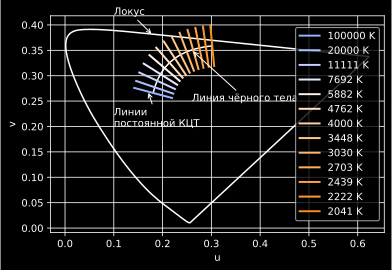

In [7]:
plt.style.use('dark_background')

# Строим линию спектрально чистых цветов
plt.plot(u, v, 'w')

# Строим линию чёрного тела
plt.plot(uv_bbline['u'], uv_bbline['v'], 'w')

# Вычисляем координаты цвета чёрного тела при 
# различных температурах в цветовом пространстве sRGB
color = []
for t in T:
    plank_spd = plank(t)
    xyz = XYZ(plank_spd)
    rgb = XYZ2sRGB(xyz)
    color.append(rgb)

# График изотерм
for u, v, c, m in zip(zip(uneg, upoz), zip(vneg, vpoz), color, mired):
    plt.plot(u, v, c = (c['R'], c['G'], c['B']), 
             label="{0:.0f} K".format(1e6/m), lw = 2)


plt.legend(loc='right' )    
plt.grid(True)
plt.xlabel('u')
plt.ylabel('v')


plt.annotate('Линия чёрного тела', xy=(0.26, 0.35), xytext=(0.26, 0.25), 
             arrowprops=dict(arrowstyle="->"))
plt.annotate('Линии\nпостоянной КЦТ', xy=(0.17, 0.27), xytext=(0.10, 0.2), 
             arrowprops=dict(arrowstyle="->"))
plt.annotate('Локус', xy=(0.18, 0.38), xytext=(0.10, 0.42), 
             arrowprops=dict(arrowstyle="->"))

#plt.savefig('constant_cct.svg')

Программный код приведённый в 4 и 5 ячейке полезен не только для построения линий постоянной КЦТ, но, как мы увидим в следующем разделе, для нахождения тангенса угла наклона линий постоянной КЦТ к оси абсцисс при составлении расчётной таблицы для определения КЦТ по методу Робертсона, а также для определения погрешности расчёта КЦТ разными методами.    

#### Задание.

*Рассчитать и построить линию чёрного тела, линии постоянной КЦТ на  графике МКО 1931 (xy).*